In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, lars_path
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn import linear_model
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# read data
df = pd.read_csv("dummt_transformed.csv")
df = df.iloc[:,1:]

In [3]:
df.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2          ...            \
0          2003       196.0         706           0          ...             
1          1976         0.0         978           0          ...             
2          2002       162.0         486           0          ...             
3          1970         0.0         216           0          ...             
4          2000       350.0         655           0          ...             

   SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0             0.0             0.0           0.0           0.0          1.0   
1             0.0             0.0           0.0           0.0          1.0   
2             0.0             0.0           0.0           0.0          1.0   
3             0.0             0.0           0.0           0.0          1.0   
4             0.0             0.0           0.0           0.0          1.0   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                    0.0                   0.0                   0.0   
1                    0.0                   0.0                   0.0   
2                    0.0                   0.0                   0.0   
3                    0.0                   0.0                   0.0   
4                    0.0                   0.0                   0.0   

   SaleCondition_Normal  SaleCondition_Partial  
0                   1.0                    0.0  
1                   1.0                    0.0  
2                   1.0                    0.0  
3                   0.0                    0.0  
4                   1.0                    0.0  

[5 rows x 260 columns]

In [4]:
# check missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total > 0]

Total   Percent
LotFrontage    259  0.177397

In [5]:
variables = df.columns.tolist()
y_index = df.columns.tolist().index('SalePrice')
NA_index = df.columns.tolist().index('LotFrontage')
y = np.log(df.iloc[:,y_index])
variables.pop(y_index)
variables.pop(NA_index)
X = df.loc[:,variables]

In [6]:
X.shape

(1460, 258)

### Ridge Regression

In [7]:
alphas = np.logspace(-6,4,11)
alphas

array([  1.00000000e-06,   1.00000000e-05,   1.00000000e-04,
         1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01,   1.00000000e+02,
         1.00000000e+03,   1.00000000e+04])

In [8]:
rcv = RidgeCV(alphas = alphas, store_cv_values=True,normalize=False)
rcv.fit(X,y)
cv_vals = rcv.cv_values_
LOOr = cv_vals.mean(axis=0)

In [9]:
zip(alphas,LOOr)

[(9.9999999999999995e-07, 0.038809216088404319),
 (1.0000000000000001e-05, 0.038804090976448463),
 (0.0001, 0.038751071957352494),
 (0.001, 0.038121104644841398),
 (0.01, 0.033248117091876264),
 (0.10000000000000001, 0.025280838356157999),
 (1.0, 0.021940136309481651),
 (10.0, 0.020738356273389717),
 (100.0, 0.021764828299675971),
 (1000.0, 0.026296499925431538),
 (10000.0, 0.033783965909834422)]

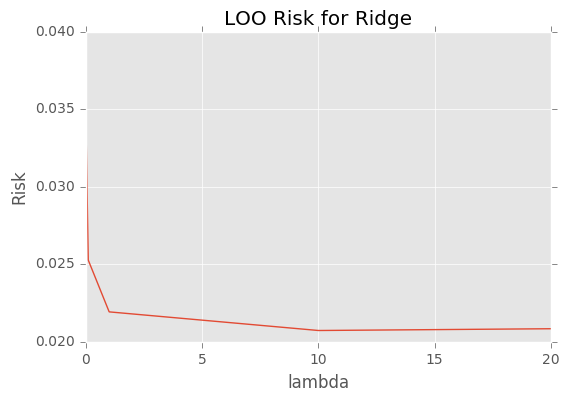

In [10]:
plt.plot(alphas,LOOr)
plt.xlabel('lambda')
plt.ylabel('Risk')
plt.title('LOO Risk for Ridge')
plt.xlim([0,20])
plt.show()

In [11]:
min(dict(zip(alphas,LOOr)).items(), key=lambda x: x[1])

(10.0, 0.020738356273389717)

In [12]:
print "LOO square error risk for ridge under the best lambda is {:.7f}".format(
    min(dict(zip(alphas,LOOr)).items(), key=lambda x: x[1])[1])

LOO square error risk for ridge under the best lambda is 0.0207384


### Lasso Path and Lars Path

In [13]:
lasso_path = lars_path(np.array(X),np.array(y),method="lasso")
#lars_path = lars_path(np.array(X),np.array(y),method="lar")

/Users/alice/anaconda/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 138 iterations, alpha=5.683e-04, previous alpha=5.654e-04, with an active set of 113 regressors.
  ConvergenceWarning)


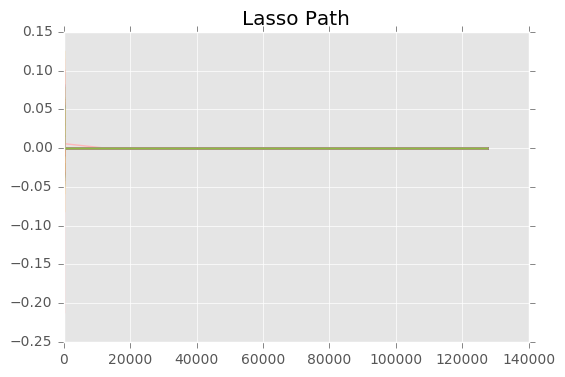

In [14]:
for j in xrange(X.shape[1]):
    _ = plt.plot(lasso_path[0],lasso_path[2][j,:])
#_ = plt.xlim([0,20])
#_ = plt.xlim(plt.xlim()[::-1])
#_ = ax[0].set_ylim([-500,500])
_ = plt.title("Lasso Path")

### Lasso

In [15]:
loo = LeaveOneOut()
looiter = loo.split(X)
lasso_model = LassoCV(cv=looiter)
lasso_model.fit(X,y)
print("The selected lambda value is {:.2f}".format(lasso_model.alpha_))

The selected lambda value is 1.03


In [16]:
np.mean(lasso_model.mse_path_[lasso_model.alphas_ == lasso_model.alpha_])

0.039885723197330136

In [17]:
X.columns[lasso_model.coef_ != 0]

Index([u'LotArea', u'YearBuilt', u'YearRemodAdd', u'MasVnrArea', u'BsmtFinSF1',
       u'TotalBsmtSF', u'2ndFlrSF', u'GrLivArea', u'GarageYrBlt',
       u'GarageArea', u'WoodDeckSF', u'ScreenPorch', u'MiscVal'],
      dtype='object')

### Fitting Ridge Regression using the variables selected by Lasso

In [18]:
variable_chosen = X.iloc[:,lasso_model.coef_ != 0]

In [19]:
alphas = np.logspace(-6,4,11)
rcv = RidgeCV(alphas = alphas, store_cv_values=True,normalize=False)
rcv.fit(variable_chosen,y)
cv_vals = rcv.cv_values_
LOOr = cv_vals.mean(axis=0)

In [20]:
min(dict(zip(alphas,LOOr)).items(), key=lambda x: x[1])

(9.9999999999999995e-07, 0.036139863571387598)

In [21]:
# The mse here is smaller than Lasso

### Random Forest Regressor

In [22]:
from sklearn.tree import DecisionTreeRegressor

In [23]:
regressor = DecisionTreeRegressor(random_state=0, max_features = 20)
np.mean(cross_val_score(regressor, X, y, cv=X.shape[0]))

0.0089041095890410957

In [24]:
regressor.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=20,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

In [25]:
X.columns[regressor.feature_importances_ != 0]

Index([u'MSSubClass', u'LotArea', u'OverallQual', u'OverallCond', u'YearBuilt',
       u'YearRemodAdd', u'MasVnrArea', u'BsmtFinSF1', u'BsmtFinSF2',
       u'BsmtUnfSF',
       ...
       u'MiscFeature_Shed', u'SaleType_CWD', u'SaleType_ConLD',
       u'SaleType_New', u'SaleType_Oth', u'SaleType_WD',
       u'SaleCondition_Alloca', u'SaleCondition_Family',
       u'SaleCondition_Normal', u'SaleCondition_Partial'],
      dtype='object', length=189)

### Adding XGBOOST

Still not figure how to do this @@

In [26]:
import xgboost as xgb